## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import math
import itertools
import matplotlib.pyplot as plt
#from lane_line import Line

%matplotlib inline

In [2]:
def plot_images(images, label=None, n_cols=5, cmap=None):
    """
    plot images in n_cols columns
    :param images 
    :param label image labels
    :param n_cols number of columns
    """
    n_rows = math.ceil(len(images)/n_cols)
 
    plt.figure(figsize=(20, n_rows*10/n_cols))   
    for i,image in enumerate(images):
        #image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        if label != None:
            plt.title("Output " + str(label[i]))
        plt.imshow(image, aspect='equal', cmap=cmap)
    plt.show()

def plot_compare_images(left_images, right_images, cmap=None):
    mixed_images = list(itertools.chain.from_iterable(zip(left_images,right_images)))
    plot_images(mixed_images, n_cols=2, cmap=cmap)
    
def plot_histogram(labels, n_labels):
    """
    Exploration of the label distribution
    """
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
cal_files = glob.glob('./camera_cal/calibration*.jpg')
# Make a list of test images
test_files = glob.glob('./test_images/*.jpg')

corner_images = []

# Step through the list and search for chessboard corners
for fname in cal_files:
    img = plt.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_images.append(img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## And so on and so forth...

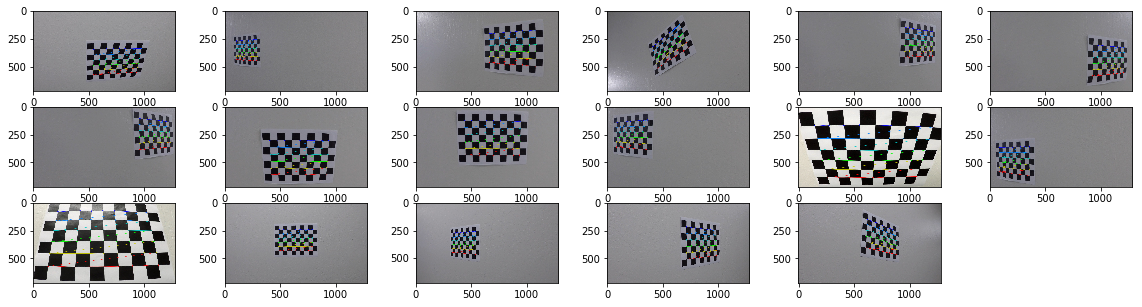

In [4]:
plot_images(corner_images, n_cols=6)

In [5]:
#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

cal_images = []
cal_distorted_images = []
for fname in cal_files:
    img = plt.imread(fname)
    cal_distorted_images.append(img)
    cal_images.append(cv2.undistort(img, mtx, dist, None, mtx))

test_images = []
for fname in test_files:
    img = plt.imread(fname)
    test_images.append(cv2.undistort(img, mtx, dist, None, mtx))

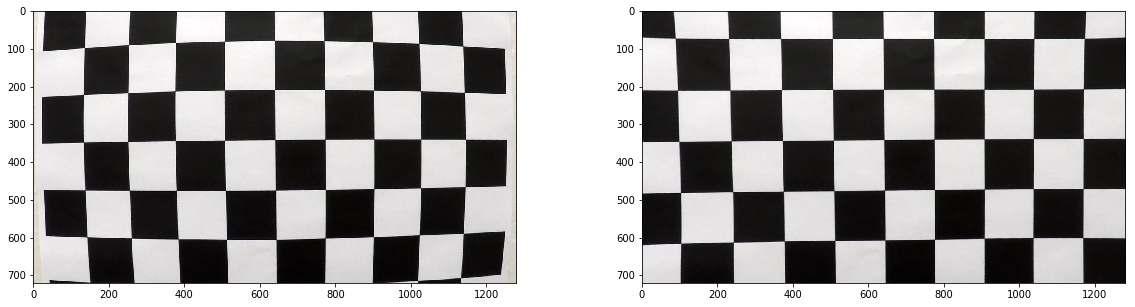

In [6]:
plot_compare_images(cal_distorted_images[0:1], cal_images[0:1])

In [7]:

def warp(img):
    '''
    '''
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [8]:
test_warped = [warp(img)[0] for img in test_images]

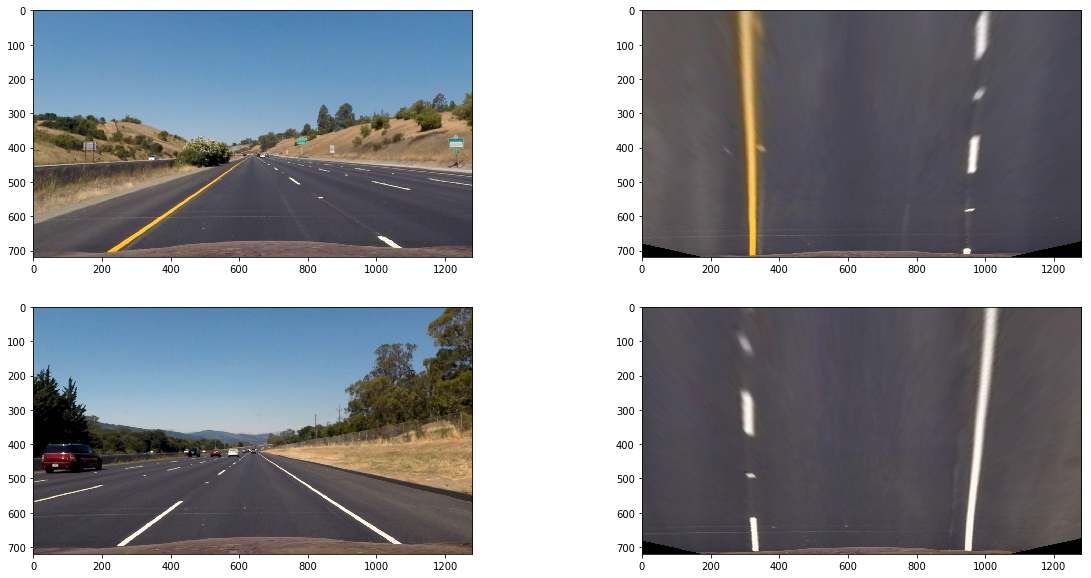

In [9]:
#print(test_warped[0].shape)
plot_compare_images(test_images[0:2], test_warped[0:2])

In [10]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def reject_outliers(data, m=2):
    """
    Reject outliers in data which are more than
    m * StandardDeviations away from the median
    """    
    return data[abs(data - np.median(data)) < m * np.std(data)] 

def select_color_code(func):
    def wrapper(img, code, *args, **kwargs):
        if code != None:
            img = cv2.cvtColor(img, code)
        func(img)
    return wrapper

def select_channel(img, channel=0):
    return None

                    
def channel_select(img, thresh=(0, 255), channel=2, code=cv2.COLOR_RGB2HLS):
    '''
    Function that thresholds the desired channel of selected color space 
    :param img: RGB input image
    :param thresh: threshold tupel from 0..255. thresh[0] < pixel <= thresh[1] are included
    :param channel: select color channel (e.g. H=0, L=1, S=2)
    :param code: 
    '''
    # use other color space than the original one
    if code != None:
        img = cv2.cvtColor(img, code)
    # select channel
    channel = img[:,:,channel]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1  
    return binary_output


def abs_sobel(sobelx, sobely):
    '''
    Take the absolute values of the sobel gradient and add/scale them    
    '''
    abs_sobel = np.absolute(sobelx) + np.absolute(sobely)
    # Rescale back to 8 bit integer
    return np.uint8(255*abs_sobel/np.max(abs_sobel))   

def mag_sobel(sobelx, sobely):
    '''
    Take the magnitude value of the sobel gradients and scale them   
    '''
    magn = np.sqrt(sobelx**2 + sobely**2)
    # Rescale back to 8 bit integer
    return np.uint8(255 * magn/np.max(magn))

def dir_sobel(sobelx, sobely):
    '''
    Use arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    '''
    return np.arctan2(np.absolute(sobelx), np.absolute(sobely))    

def sobel_thresh(img, thresh=(0,255), sobel_kernel=9, orient='xy', func=abs_sobel):
    '''
    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray[:,:,0].shape)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient == 'x':
        sobely = 0
    elif orient == 'y':
        sobelx = 0
    # apply function on sobel values, e.g. magnitude, direction
    scaled_sobel = func(sobelx, sobely)   
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output = cv2.adaptiveThreshold(scaled_sobel,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    # Return the result
    return binary_output


def stack_binaries(first, second):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    return np.dstack(( first, second, np.zeros_like(first)))

def combine_binaries(first, second):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(first)
    combined_binary[(first == 1) | (second == 1)] = 1
    return combined_binary

In [11]:
test_images = [gaussian_blur(img, 5) for img in test_images]

In [12]:
h_binaries = [channel_select(img, thresh=(90,225), channel=0) for img in test_images]
l_binaries = [channel_select(img, thresh=(90,225), channel=1) for img in test_images]
s_binaries = [channel_select(img, thresh=(90,225), channel=2) for img in test_images]
r_binaries = [channel_select(img, thresh=(225,255), channel=0, code=None) for img in test_images]

mag_binaries = [sobel_thresh(img, thresh=(50,100),func=mag_sobel) for img in test_images]
#dir_test_images = [sobel_thresh(img, thresh=(0.7, 1.2),func=dir_sobel) for img in test_images]
abs_binaries = [sobel_thresh(img, thresh=(15, 255),func=abs_sobel, orient='x', sobel_kernel=3) for img in test_images]
r_abs_stack_binaries = [stack_binaries(r, abs) for r,abs in zip(r_binaries, abs_binaries)]
r_abs_binaries = [combine_binaries(r, abs) for r,abs in zip(r_binaries, abs_binaries)]

In [51]:
h_warped = [channel_select(img, thresh=(90,225), channel=0) for img in test_warped]
l_warped = [channel_select(img, thresh=(150,225), channel=1) for img in test_warped]
s_warped = [channel_select(img, thresh=(140,255), channel=2) for img in test_warped]
r_warped = [channel_select(img, thresh=(225,255), channel=0, code=None) for img in test_warped]

mag_warped = [sobel_thresh(img, thresh=(20,100),func=mag_sobel) for img in test_warped]
dir_warped = [sobel_thresh(img, thresh=(0.7, 1.2),func=dir_sobel) for img in test_warped]
abs_warped = [sobel_thresh(img, thresh=(55, 255),func=abs_sobel, orient='x', sobel_kernel=9) for img in test_warped]
r_s_warped = [combine_binaries(r, s) for r,s in zip(r_warped, s_warped)]
abs_r_s_warped = [combine_binaries(r, s) for r,s in zip(r_s_warped, abs_warped)]

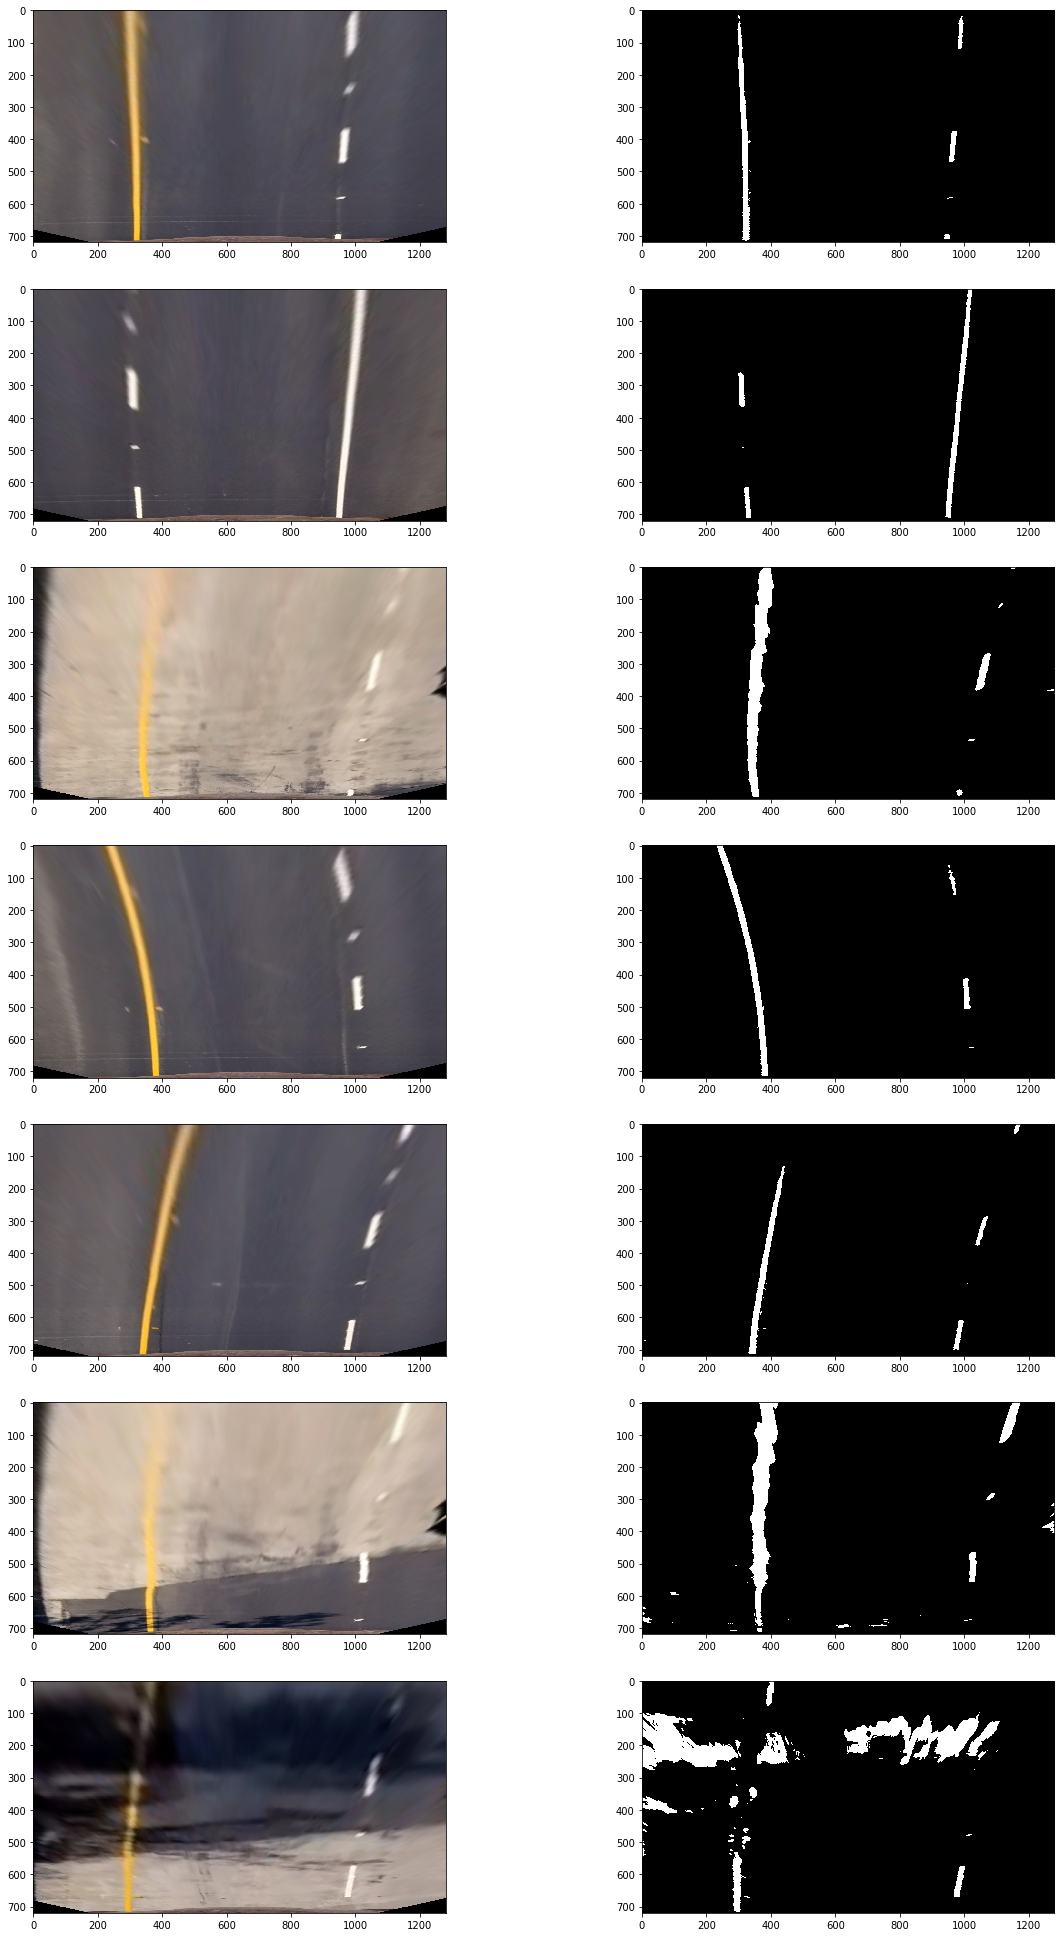

In [14]:
plot_compare_images(test_warped[0:-1], r_s_warped [0:-1], cmap='gray')

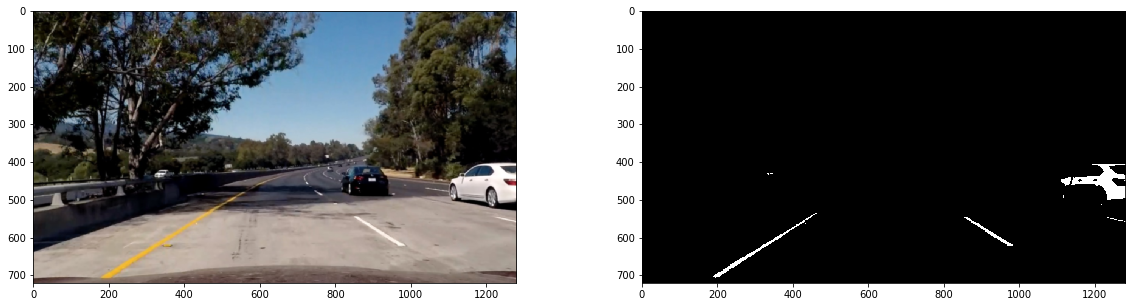

In [15]:
plot_compare_images(test_images[-2:-1], r_binaries[-2:-1], cmap='gray')

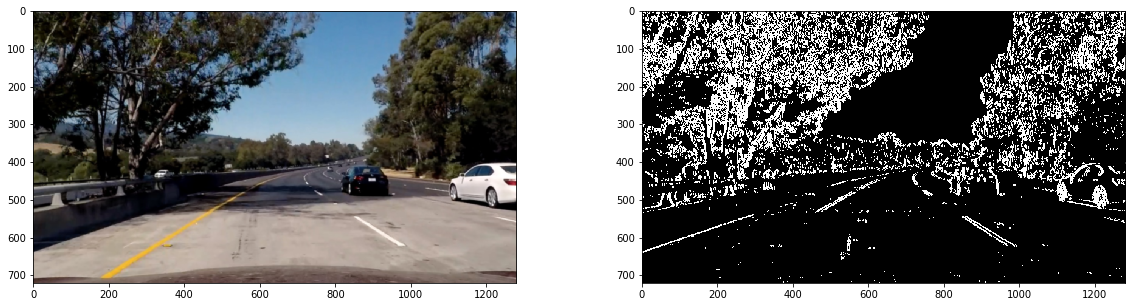

In [16]:
plot_compare_images(test_images[-2:-1], abs_binaries[-2:-1], cmap='gray')

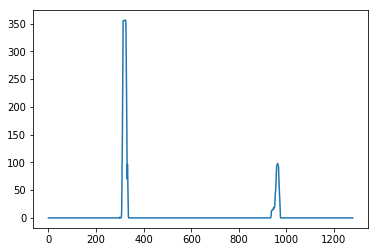

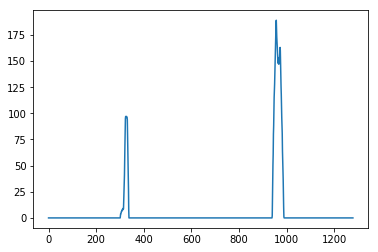

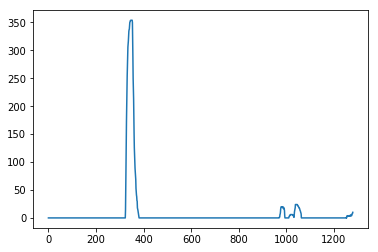

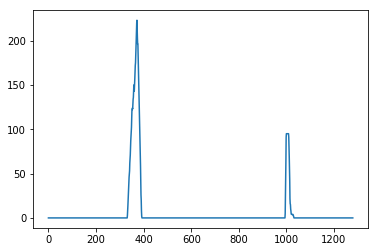

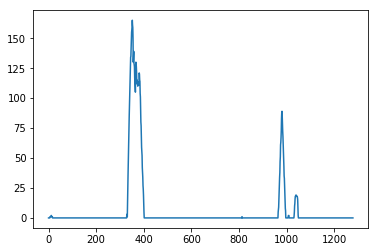

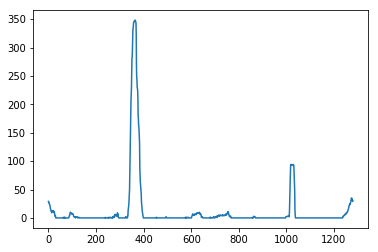

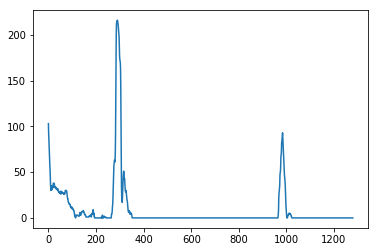

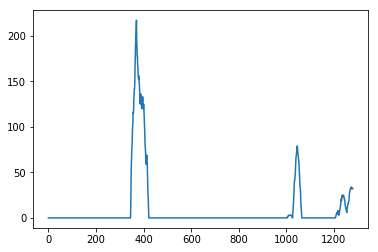

In [17]:
histograms = [np.sum(img[int(img.shape[0]/2):,:], axis=0) for img in r_s_warped]
for h in histograms:
    plt.plot(h)
    plt.show()

In [52]:
def binary2image(binary_image):
    return np.dstack((binary_image, binary_image, binary_image))*255

def nonzero_x_y(image):
    """
    Identify the x and y positions of all nonzero pixels in the image
    """ 
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

In [19]:
def get_lane_base(binary_warped):
    """
    find the basepoints, midpoint, left and right lane base
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

_, leftx_base, rightx_base = get_lane_base(binary_warped)

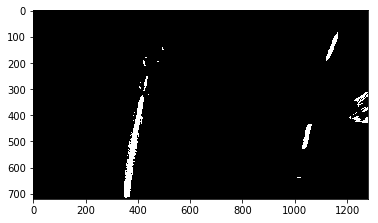

10115


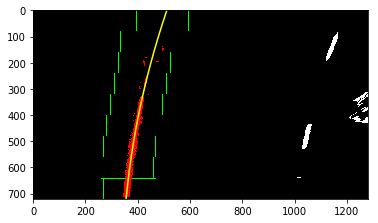

3367


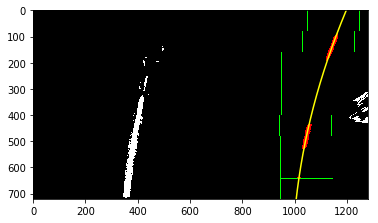

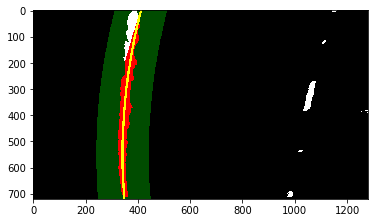

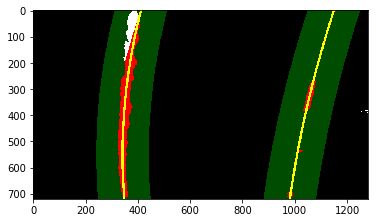

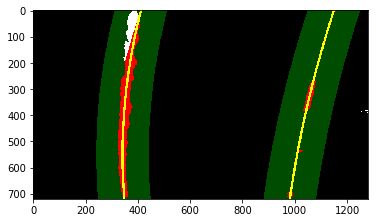

In [139]:
binary_warped = r_s_warped[-1]
out_img = binary2image(binary_warped)
plt.imshow(out_img)
plt.show()

%run lane_line.py
left_line = Line()
right_line = Line()
left_line.fit_sliding_window(binary_warped, leftx_base, plot=True)
right_line.fit_sliding_window(binary_warped, rightx_base, plot=True)

binary_warped = r_s_warped[2]
out_img = binary2image(binary_warped)

left_line.fit_previous(binary_warped)
right_line.fit_previous(binary_warped)
out_img = left_line.draw_poly(out_img)
out_img = right_line.draw_poly(out_img)
right_line.draw_fit(out_img)

plt.imshow(out_img)
plt.show()

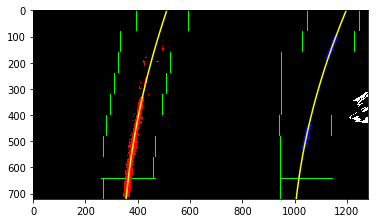

In [71]:
def gen_plot_fit_data(img, left_fit, right_fit):
    """
    Generate plotting data from fitting paramterts 
    """
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def fit_sliding_window(binary_warped, lefx_base, rightx_base, nwindows=9, margin=100, minpix = 40, plot=False):
    """
    :param margin Set the width of the windows +/-
    :param minpix Set minimum number of pixels found to recenter window
    """
    # Create an output image to draw on and  visualize the result
    out_img = binary2image(binary_warped)    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox, nonzeroy = nonzero_x_y(binary_warped)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & \
                          (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & \
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & \
                           (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) & \
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot:
        # Generate x and y values for plotting
        ploty, left_fitx,right_fitx = gen_plot_fit_data(binary_warped, left_fit,right_fit)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)        
    
    return left_fit, right_fit

binary_warped = r_s_warped[-1]
left_fit, right_fit = fit_sliding_window(binary_warped, leftx_base, rightx_base, plot=True)

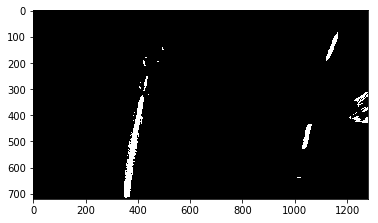

In [72]:
out_img = binary2image(binary_warped)
plt.imshow(out_img)
plt.show()

In [73]:
binary_warped = r_s_warped[2]
left_fit, right_fit = fitP(binary_warped, left_fit, right_fit)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

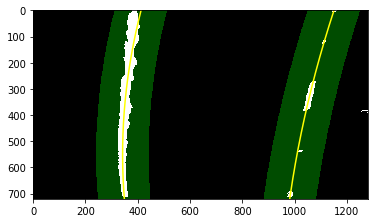

In [74]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
#out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)